In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
try:
    from google.colab import drive

    drive.mount('/content/drive')

    %cd ./drive/MyDrive/NewsGeneration-NLP-Teknofest/Model/
except ImportError:
    print("You are not in a Google Colab environment.")
    pass

Mounted at /content/drive
/content/drive/MyDrive/NewsGeneration-NLP-Teknofest/Model


In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys

sys.path.append('../Preprocess-Data/')
from category_reducer import category_reducer

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

from tensorflow import expand_dims

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D

from tensorflow.keras.applications import MobileNetV2, mobilenet_v2

from tensorflow.keras.layers import Conv2D, Flatten, Reshape
from tensorflow.keras.layers import Embedding, LSTM, Dense, concatenate

from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings("ignore")

In [53]:
def load_data():
    '''
    # Load the data from the csv file and reduce the number of categories
    '''
    data_path = "../Data/news-data-with-imgs.csv"
    data = pd.read_csv(data_path)
    df = data.copy()

    df = category_reducer(df)
    print(df.info())
    df = df[['Content', 'Title', 'img_path']]
    return df

df = load_data()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Title                1000 non-null   object
 1   Content              1000 non-null   object
 2   Content_url          1000 non-null   object
 3   News_type            1000 non-null   object
 4   Day_month_year_hour  1000 non-null   object
 5   Img_url              1000 non-null   object
 6   img_path             1000 non-null   object
dtypes: object(7)
memory usage: 54.8+ KB
None


In [54]:
class PreprocessImg:
    '''
    # Class to preprocess the images and get the size information of the images.
    '''
    def __init__(self, df):
        self.loaded_imgs = []
        self.img_arrays = []
        self.df = df

    def load_img(self, target_size=None):
        for img in self.df['img_path']:
            img = img.replace('\\', '/')
            img = load_img(img, target_size=target_size)
            self.loaded_imgs.append(img)

        return self.loaded_imgs

    def img_to_array(self):
        '''
        # Load the images from the directory

        Returns:
            - loaded_imgs: List of loaded images
        '''
        for img in self.loaded_imgs:
            img = img_to_array(img)
            self.img_arrays.append(img)

        return np.array(self.img_arrays) / 255.0

    def get_size_info(self, loaded_imgs):
        '''
        # Get the size information of the images

        Args:
            - loaded_imgs: list of loaded images

        Returns:
            - weights_mean: Mean of the weights of the images
            - weights_std: Standard deviation of the weights of the images
            - heights_mean: Mean of the heights of the images
            - heights_std: Standard deviation of the heights of the images
        '''
        img_weights = []
        img_heights = []
        for size in loaded_imgs:
            img_weights.append(size.size[0])
            img_heights.append(size.size[1])

        max_weight = max(img_weights)
        min_weight = min(img_weights)
        weights_mean = np.mean(img_weights)
        weights_std = np.std(img_weights)

        max_height = max(img_heights)
        min_heigth = min(img_heights)
        heights_mean = np.mean(img_heights)
        heights_std = np.std(img_heights)

        print("Max width: ", max_weight)
        print("Min width: ", min_weight)
        print("Mean width:", weights_mean)
        print("Standard deviation of widths:", weights_std)
        print("==")
        print('Max height:', max_height)
        print('Min height:', min_heigth)
        print("Mean height:", heights_mean)
        print("Standard deviation of heights:", heights_std)

In [55]:
img_preprocessor = PreprocessImg(df)

loaded_imgs = img_preprocessor.load_img(target_size=(224, 224))
image_data = img_preprocessor.img_to_array()

img_preprocessor.get_size_info(loaded_imgs)
print('Image shapes: ', image_data.shape)

Max width:  224
Min width:  224
Mean width: 224.0
Standard deviation of widths: 0.0
==
Max height: 224
Min height: 224
Mean height: 224.0
Standard deviation of heights: 0.0
Image shapes:  (1000, 224, 224, 3)


In [56]:
class PreprocessText(Tokenizer):
    '''
    # Class to tokenize and pad the text data

    Args:
        - data: The text data list or series to be tokenized and padded
    '''
    def __init__(self, data):
        super().__init__(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')

        self.start_mark = '<start> '
        self.end_mark = ' <end>'

        self.data = data.apply(lambda x: self.start_mark + x + self.end_mark)

        self.fit_on_texts(self.data)
        self.tokens = self.texts_to_sequences(self.data)

        self.vocab_size = len(self.word_index) + 1
        self.numbers_of_words = [len(token) for token in self.tokens]
        self.max_tokens = max(self.numbers_of_words)

        self.padded_tokens = pad_sequences(self.tokens, padding='post', truncating='post')

    # padding the token
    @staticmethod
    def pad_data(text, max_tokens=None):
        '''
        # Pad the tokens to a new maximum length

        Args:
            - text: The tokens to be padded
            - max_tokens: The maximum length of the tokens

        Returns:
            - np.array: The padded tokens
        '''
        padded_tokens = pad_sequences(text, maxlen=max_tokens, padding='post', truncating='post')
        return padded_tokens

    def generate_data(self, image_data):
        '''
        # Generate the data for the model based on the next word prediction.
        # First token is input and the second token is output and so on till the end of the sequence.

        * Example:
            - title = "Sel felaketi sonucu 3 vatandaş kayıp"
            - word_index = {'Sel': 9, 'felaketi': 5, 'sonucu': 3, '3': 7, 'vatandaş': 5, 'kayıp': 6 }
            - tokens: [start_token, 9, 5, 3, 7, 5, 6, end_token]

            | Input                                         |   Output    |
            | --------------------------------------------  | ----------  |
            | Image + start_token                           |     9       |
            | Image + start_token + 9                       |     5       |
            | Image + start_token + 9 + 5                   |     3       |
            | Image + start_token + 9 + 5 + 3               |     7       |
            | Image + start_token + 9 + 5 + 3 + 7           |     5       |
            | Image + start_token + 9 + 5 + 3 + 7 + 5       |     6       |
            | Image + start_token + 9 + 5 + 3 + 7 + 5 + 6   |  end_token  |

        Args:
            - image_data: The image data
            - max_tokens: The maximum length of the tokens

        Returns:
            - np.array: The image and text data
        '''
        X_images_list, X_texts_list, y_texts_list = [], [], []

        for img, seq in zip(image_data, self.padded_tokens):
            for i in range(1, len(seq)):
                in_seq, out_seq = seq[:i], seq[i]
                in_seq = pad_sequences([in_seq], maxlen=self.max_tokens)[0]
                out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                X_images_list.append(img)
                X_texts_list.append(in_seq)
                y_texts_list.append(out_seq)

        self.X_images = np.array(X_images_list)
        self.X_texts = np.array(X_texts_list)
        self.y_texts = np.array(y_texts_list)

        return self.X_images, self.X_texts, self.y_texts

    def token_to_text(tokens):
        """
        # Convert the tokens to text

        Args:
            - tokens: The tokens to be converted

        Returns:
            - str: The text
        """
        text = ' '.join(tokenizer.index_word[token] for token in tokens)
        return text

    def text_to_token(text):
        """
        # Convert the text to tokens

        Args:
            - text: The text to be converted

        Returns:
            - list: The tokens
        """
        tokens = tokenizer.texts_to_sequences([text])[0]
        return tokens
    def get_info(self):
        '''
        # Get the information about the tokenized and padded data
        '''
        print("Max tokens: ", self.max_tokens)
        print("Min tokens: ", min(self.numbers_of_words))
        print("Mean tokens: ", int(np.mean(self.numbers_of_words)))
        print("Standard deviation of tokens: ", int(np.std(self.numbers_of_words)))
        print("Vocabulary Size: ", len(self.word_index) +1 )
        print('Shape of padded tokens: ', self.padded_tokens.shape)
        print('X_images shape: ', self.X_images.shape)
        print('X_texts shape: ', self.X_texts.shape)
        print('y_texts shape: ', self.y_texts.shape)

In [57]:
tokenizer = PreprocessText(df['Title'])

padded_tokens = tokenizer.padded_tokens
max_tokens = tokenizer.max_tokens
vocab_size = tokenizer.vocab_size

start_token = tokenizer.word_index[tokenizer.start_mark.strip()]
end_token = tokenizer.word_index[tokenizer.end_mark.strip()]

X_images, X_texts, y_texts = tokenizer.generate_data(image_data)

tokenizer.get_info()

Max tokens:  26
Min tokens:  4
Mean tokens:  9
Standard deviation of tokens:  2
Vocabulary Size:  3550
Shape of padded tokens:  (1000, 26)
X_images shape:  (25000, 224, 224, 3)
X_texts shape:  (25000, 26)
y_texts shape:  (25000, 3550)


In [58]:
class Img2TextModel():
    """
    # Image captioning model that generate meaningfull context and title from and image.
    """
    @staticmethod
    def CNN_encoder():
        """
        # Encoder with MobileNetV2.
        """
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        base_model.trainable = False

        input_layer = Input(shape=(224, 224, 3), name='encoder_input')
        x = base_model(input_layer)
        x = Conv2D(filters=256, kernel_size=(3, 3), activation='relu')(x)
        x = GlobalAveragePooling2D(name='global_average_pooling2d')(x)
        x = Dense(256, activation='relu', name='encoder_dense_1')(x)
        output_layer = Dense(128, activation='relu', name='encoder_output')(x)

        return input_layer, output_layer

    @staticmethod
    def LSTM_decoder():
        """
        # Decoder with LSTM.
        """
        input_layer = Input(shape=(None, ), name='decoder_input')
        embedding_layer = Embedding(input_dim=vocab_size, output_dim=300, input_length=max_tokens, name='decoder_embedding')(input_layer)
        lstm_layer = LSTM(256, return_sequences=True, name='LSTM_layer_1')(embedding_layer)
        lstm_layer = LSTM(128, name='LSTM_layer_2')(lstm_layer)

        return input_layer, lstm_layer

    def build_model(self):
        """
        # Concat layers and build model.
        """
        encoder_input, encoder_output = self.CNN_encoder()
        decoder_input, decoder_output = self.LSTM_decoder()

        combined = concatenate([encoder_output, decoder_output])
        output = Dense(vocab_size, activation='softmax', name='model_output')(combined)

        self.model = Model(inputs=[encoder_input, decoder_input], outputs=output)
        self.model.compile(loss='categorical_crossentropy', optimizer='adam')

        return self.model

In [62]:
model = Img2TextModel()

model = model.build_model()

In [63]:
es = EarlyStopping(monitor='loss', patience=5, verbose=1)

model.fit([X_images, X_texts],
          y_texts,
          epochs=50,
          batch_size=64,
          callbacks=[es])

Epoch 1/50
391/391 [==============================] - 201s 499ms/step - loss: 2.4853
Epoch 2/50
391/391 [==============================] - 200s 511ms/step - loss: 2.1284
Epoch 3/50
391/391 [==============================] - 200s 511ms/step - loss: 1.9325
Epoch 4/50
391/391 [==============================] - 201s 513ms/step - loss: 1.7379
Epoch 5/50
391/391 [==============================] - 201s 514ms/step - loss: 1.5462
Epoch 6/50
391/391 [==============================] - 202s 517ms/step - loss: 1.3619
Epoch 7/50
391/391 [==============================] - 202s 517ms/step - loss: 1.1829
Epoch 8/50
391/391 [==============================] - 202s 517ms/step - loss: 1.0118
Epoch 9/50
391/391 [==============================] - 203s 518ms/step - loss: 0.8558
Epoch 10/50
391/391 [==============================] - 203s 519ms/step - loss: 0.7171
Epoch 11/50
391/391 [==============================] - 202s 517ms/step - loss: 0.5980
Epoch 12/50
391/391 [==============================] - 204s 522

In [66]:
plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [67]:
def generate_text(index):

  test_image = image_data[index]
  real_title = df['Title'][index]

  initial_caption = '<start>'
  max_caption_length = 20

  initial_caption_seq = tokenizer.texts_to_sequences([initial_caption])[0]
  initial_caption_seq = pad_sequences([initial_caption_seq], maxlen=max_tokens)

  final_caption = []

  for i in range(100):
      predictions = model.predict([np.expand_dims(test_image, axis=0), initial_caption_seq])

      predicted_word_index = np.argmax(predictions)

      try:
        predicted_word = tokenizer.index_word[predicted_word_index]
      except KeyError:
        predicted_word = "<UNKNOWN>"
        pass

      if predicted_word == '<end>':
          break

      final_caption.append(predicted_word)

      initial_caption_seq = pad_sequences([initial_caption_seq[0].tolist() + [predicted_word_index]], maxlen=max_tokens)

  final_caption = ' '.join(final_caption)

  plt.imshow(test_image)
  plt.axis("off")
  plt.show()
  print
  print("Generated title")
  print(final_caption)
  print("Real title")
  print(real_title)

1/1 [==============================] - 0s 44ms/step


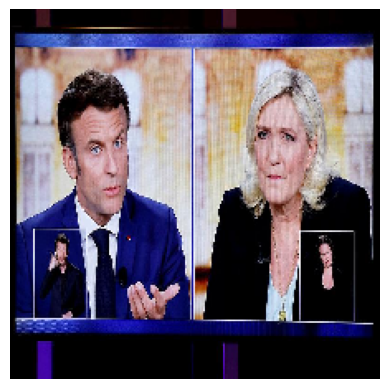

Generated title
macron ve le pen canlı yayında tartıştı
Real title
Macron ve Le Pen canlı yayında tartıştı


In [70]:
generate_text(10)